# Brief user guide for the [**RandomForestDist**](https://github.com/MNLR/RandomForestDist) package 

This companion notebook briefly explains how to use the main functionalities provided by the `R` package [RandomForestDist](https://github.com/MNLR/RandomForestDist) and presents the code needed to reproduce part of the experiments presented in the article *Adapting Random Forests for Stochastic Downscaling of Rainfall Based on Local Estimated Probability Distributions*, submitted to *Water Resources Research* by *Legasa et al.* in 2021. In that work, random forests (RFs) are applied to the problem of statistical downscaling of rainfall. In particular, the authors analyze the suitability of different split functions which allow to work with non-normally distributed variables and propose a novel a posteriori (AP) approach which permits to accurately estimate the shape and rate parameters of the underlying rainfall distribution, which in turn allows for generating reliable stochastic rainfall series. 

[RandomForestDist](https://github.com/MNLR/RandomForestDist) requires a modified version of [rpart](https://cran.r-project.org/web/packages/rpart/index.html) which can be found [here](https://github.com/MNLR/rpart). In order to run the examples provided below, these two packages need to be first installed. This can be easily done from GitHub using the `devtools` package: 

In [ ]:
devtools::install_github("MNLR/rpart")
install.packages(c("progressr", "qmap", "fitdistrplus"))
devtools::install_github("MNLR/RandomForestDist")

We start by loading `RandomForestDist` and `VALUE9`, a dataset included in the package which contains daily series of rainfall for 9 illustrative meteorological stations over Europe along with the 17 large-scale reanalysis predictors used for statistical downscaling (see the paper for details).

In [1]:
library(RandomForestDist)
data(VALUE9)

Loading required package: rpart

Loading required package: progressr



`VALUE9` is a list of 9 elements (one per station), being the data already divided into a stratified 5-fold (F1 = 1979-1984, F2 = 1985-1990, F3 = 1991-1996, F4 = 1997-2002, F5 = 2003-2008). `$train.y`(training set) and `$test.y` (test set) correspond to the predictands; `$train.x` (training set) and `$test.x` (test set) are the predictors. For example, for the first station and fold:

In [2]:
head(cbind(VALUE9[[1]]$f1_79_84$train.y, VALUE9[[1]]$f1_79_84$train.x))

5.4,100934.56,101076.31,101029.38,101127.6,0.9725891,-0.5552429,3.362726,1.4769836,53970.78,⋯,0.0008774727,0.0007474154,0.001837683,0.001404357,0.002788675,0.002296162,0.003939099,0.003326243,0.004503078,0.004167265
3.0,99861.81,100098.66,99890.75,100026.2,4.0751587,2.3417603,6.654260,4.7987915,53126.36,⋯,0.0007746874,0.0008232652,0.002964854,0.003158688,0.002753138,0.002897739,0.004851500,0.004605810,0.004810254,0.004700223
5.0,100774.52,101000.39,101343.70,101556.2,1.7720581,0.8526245,3.237878,0.7207886,53762.79,⋯,0.0008526679,0.0009968218,0.002528636,0.002547173,0.002720682,0.002845912,0.004383934,0.003969920,0.004411114,0.003889335
12.9,100790.47,100810.84,101059.16,101159.5,4.7946411,4.9987427,7.108118,5.1798950,54141.42,⋯,0.0013121588,0.0011717600,0.002218187,0.002100289,0.002669751,0.002809047,0.004955770,0.004400434,0.005563976,0.005303564
11.0,99843.41,99968.94,100306.59,100510.2,8.2443481,8.8000122,9.919641,7.6437622,53829.54,⋯,0.0012456127,0.0012676665,0.003520003,0.003533235,0.004003754,0.004093757,0.006390568,0.006163236,0.006739852,0.006437775
1.0,99936.30,99915.36,100108.30,100281.5,7.5472656,9.0443359,10.253320,8.7977539,53769.01,⋯,0.0014264237,0.0015940617,0.003558955,0.004082522,0.003949782,0.004051825,0.005973617,0.006448189,0.006836812,0.006869952


## Training the models
To illustrate the training process, let's just focus on the sixth station and first fold:

In [3]:
train.x <- VALUE9[[6]]$f1_79_84$train.x  # predictors for the train period
train.y <- VALUE9[[6]]$f1_79_84$train.y  # predictand (rainfall) for the train period

The function `randomForestTrain()` builds the model for the predictors `x` and predictands `y`.

In [4]:
rf <- randomForestTrain(x = train.x, y = train.y)  # building/training a default RF

The user can specify the desired values for the parameters `mtry` (number of predictors to randomly use as candidate split variables), `ntree` (number of trees in the forest), `minbucket` (minimum number of elements each leaf is required to have), `minsplit` (minimum number of elements each node is required to have to attempt the splitting) and `maxdepth` (maximum depth allowed for each tree).

In [5]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 25, mtry = 22, 
                        minbucket = 10, minsplit = 30, maxdepth = 10)  # building/training a customized RF

By default, RFs consider the root mean squared error as split function. However, [RandomForestDist](https://github.com/MNLR/RandomForestDist) allows for using different split functions (`split.function` argument), which have been defined in the [modified version of `rpart`](https://github.com/MNLR/rpart). Currently supported options are `"anova", "poisson", "class", "exp", "gammaLLMME", "gammaLLmean", "bernoulliGammaLLMME", "gammaDeviation", "gammaLLBC3", "bernoulliLL"` and `"binaryCrossEntropyGammaDeviation"`. 

In *Legasa et al. 2021*, we restrict ourselves to the 2-parameter gamma distribution family, with different estimators (see the paper for details).

In [6]:
# NOTE: This chunk may take a while:
rf.dev <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaDeviation")
rf.LLMME <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLMME")
rf.LLBC3 <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, method = "gammaLLBC3")

## Parallelization

The training process can be parallelized by means of the package `future.apply`. This package has to be installed independently, otherwise parallelization will not be an option. Use `install.packages(future.apply)` to install it, which will also install the dependency `future`. The simplest way to use parallelization is by setting `parallel.plan = "auto"`, which will automatically use all the available cores to train the model in parallel.

In [7]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10,
                        method = "gammaDeviation",
                        parallel.plan = "auto")  # training a RF with parallelization

If not set to `"auto"`, `paralell.plan` will use the execution plan stored in the `strategy` argument of `future::plan()`. The interested reader is referred to the packages `future` and `future.apply` for details on the available options. As an example, the following block of code shows how parallelization in 4 cores can be achieved in combination with the argument `workers` and setting `parallel.plan` to `multisession`:

In [8]:
rf <- randomForestTrain(x = train.x, y = train.y, ntree = 100, minbucket = 10, 
                        method = "gammaDeviation", 
                        parallel.plan = future::multisession, workers = 4)  # training a customized RF with parallelization using 4 workers

Also, if missing or set to `NULL` (default), the function will use the current execution plan. This is useful to configure a customized plan outside the function, as we do in the next example. In particular, we set the execution to `multisession()` prior to launching the loop and train several models using this plan (do not forget to close the sessions by reverting to `sequential()`).

In [9]:
future::plan(future::multisession, workers = 4) # sets the plan to multisession and 4 workers

rfs <- lapply(VALUE9[[1]], function(fold){ # we iterate over the folds...
    return(
        randomForestTrain(x = fold$train.x, y = fold$train.y, ntree = 25, minbucket = 10, 
                          method = "gammaDeviation",
                          parallel.plan = NULL) #... and train the models
    )
    
})

future::plan(future::sequential) # reverts plan to sequential()

Note that using `parallel.plan = NA` will avoid parallelization altogether. This is the default if `future.apply` is not available.

## Generating the predictions

Once the RF is trained, out-of-sample predictors (`$test.x`) can be used to obtain the corresponding downscaled predictions with the function `randomForestPredict()`. The default configuration of `randomForestPredict()` considers the mean as aggregation function (this is the standard procedure in RFs; see the paper for details):

In [10]:
test.x <- VALUE9[[6]]$f1_79_84$test.x  # predictors for the test period
test.y <- VALUE9[[6]]$f1_79_84$test.y  # predictand (rainfall) for the train period

# We use the RF with 100 trees and gammaDeviation split function that we have already learnt to predict daily rainfall:
pr <- randomForestPredict(rf, newdata = test.x)  # predictions for the test period, considering the mean as aggregation function
head(pr)

1         2         3         4         5         6 
 6.692882  2.603507  4.302768  2.225153  4.257583 10.801592

The parameter `bagging.function` can be used to apply other aggregation functions (e.g.the median). Also, if set to `NA`, `randomForestPredict()` will provide the predictions returned by all the individual trees.

In [11]:
pr.median <- randomForestPredict(rf, newdata = test.x, bagging.function = median)  # median as aggregation function
pr.alltrees <- randomForestPredict(rf, newdata = test.x, bagging.function = NA)
pr.alltrees[1:10,]  # 10 first predictions returned by the 100 trees

1,1.8250000,5.2857143,2.640000,5.9166667,4.6578947,7.187500,5.083333,2.6692308,16.310526,3.569231,⋯,2.9142857,5.247059,7.9000000,7.1315789,7.576471,2.938462,4.516667,14.2583333,17.1200000,5.600000
2,0.9636364,2.0363636,4.282353,0.7727273,1.5142857,4.800000,2.240000,0.4000000,2.487500,1.322222,⋯,1.7900000,5.247059,0.7444444,0.3181818,1.061538,0.350000,1.418750,3.8500000,0.2272727,1.347059
3,4.3529412,5.2857143,2.133333,5.9166667,4.8800000,1.961538,2.780000,1.9363636,4.209091,1.917647,⋯,1.7900000,5.060000,5.4526316,6.3166667,7.845455,1.990000,1.418750,3.8571429,3.3071429,5.600000
4,1.1357143,5.2857143,2.133333,1.2909091,0.9818182,1.616667,0.950000,0.8727273,0.820000,5.100000,⋯,0.4636364,3.194444,1.7705882,0.9400000,1.630000,1.100000,1.208333,2.3157895,1.4200000,1.347059
5,2.4230769,2.0700000,2.761538,1.9100000,3.2315789,1.609091,2.081818,0.6352941,4.476923,6.927273,⋯,6.9769231,7.361538,4.0882353,1.7684211,1.691667,3.878571,2.390000,0.9545455,4.9500000,5.836364
6,13.3000000,9.5800000,8.190909,9.7200000,6.3125000,13.523529,21.430000,11.1727273,4.300000,14.184615,⋯,10.5200000,10.427273,18.7600000,19.7083333,17.955556,2.118750,8.800000,9.8461538,3.4285714,22.292308
7,12.5000000,11.6894737,9.240000,14.2166667,2.1142857,13.523529,2.991667,5.1846154,6.550000,13.840000,⋯,4.5181818,19.800000,18.0846154,9.5526316,2.900000,3.036364,6.161538,5.2545455,5.5200000,10.476923
8,1.7764706,0.8666667,2.747059,2.4857143,1.5916667,4.680000,2.240000,1.8100000,12.400000,2.850000,⋯,5.7692308,2.831250,3.6000000,5.3181818,4.900000,2.000000,3.480000,8.9909091,4.0944444,5.450000
9,8.8666667,6.4153846,10.507143,12.2454545,9.6153846,4.090000,15.433333,3.5300000,17.660000,10.480000,⋯,5.7000000,11.013333,14.0500000,8.7923077,9.133333,5.537500,10.920000,6.3888889,5.8235294,7.769231
10,11.2888889,14.5333333,12.300000,14.0666667,13.6181818,16.290000,13.523077,11.5375000,8.636364,9.153333,⋯,12.2529412,11.013333,14.2230769,10.6187500,9.218750,11.927778,12.405263,11.8176471,5.8769231,14.330000


The parameter `method` controls the *a posteriori* approach (the reader is referred to the paper for details). The available options are described in the help page (`?randomForestPredict`), and we summarize them here. If `method` is not `NULL`, the argument `bagging.function` is ignored.

- `method = "leaves"` provides all the observations for each prediction.
- `method = "random.sample"` draws a random sample from the leaves for each prediction. 
- `method = "aposteriori"` returns the parameter of the probability distribution of `train.y | train.x`, as estimated using Moments Matching Estimation (refer to `fitdistrplus::fitdist()`). In the case of the gamma distribution, its shape and rate parameters are returned. `method = "bc3"` uses BC3 estimators for the gamma distribution. Additionally, this parameter can be used to select the estimation method (see `fitdistrplus::fitdist()`), i.e., one of the following: `"mme"` (Moments Matching Estimation; default),`"mle"` (Maximum Likelihood Estimation), `"qme"` (Quantile Matching Estimation), `"mge"` (Maximum Goodness-of-fit Estimation), `"mse"` (Maximum Spacing Estimation). Note that some of these options require additional parameters (use `...`), and some of them may not converge.

We provide some examples below.

Setting the parameter `method = "leaves"` allows us to plot `train.y | train.x`, for instance:

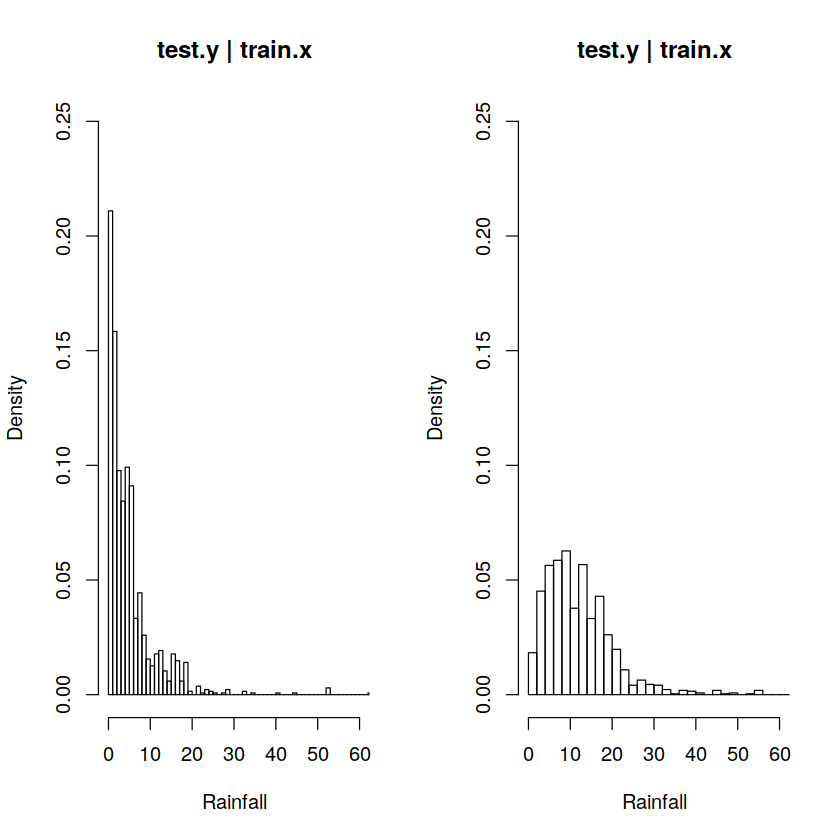

In [12]:
pr.leaves <- randomForestPredict(rf, newdata = test.x, method = "leaves") # we predict the observations falling on leaves

# and plot the histogram of their distribution:
par(mfrow = c(1,2)) 
hist(pr.leaves[[100]], breaks = 50, xlab = "Rainfall", freq = FALSE,
     main = "test.y | train.x", ylim = c(0, 0.25), xlim = c(0,60))
hist(pr.leaves[[300]], breaks = 50, xlab = "Rainfall", freq = FALSE, 
     main = "test.y | train.x",ylim = c(0, 0.25), xlim = c(0,60))

As the model was trained using the *deviation* for the 2 parameter gamma distribution, using `method = "aposteriori"` provides the shape and rate parameters for each prediction:

In [13]:
pr.distr <- randomForestPredict(rf, newdata = test.x, method = "aposteriori")
pr.distr[1:10,] # We show the first 10 predicted outcomes 

shape,rate
0.9677957,0.1419155
0.7862478,0.2982816
1.3759968,0.3128242
0.7537063,0.3403316
1.0151516,0.2371556
1.4834291,0.1391585
1.5673480,0.1938595
1.2676882,0.3518086
2.6937874,0.2916631
4.7145554,0.3804880


As stated above, the user can also specify the estimator used. For instance, rather than the Moments Matching Estimation (default) we could use the Maximum Likelihood Estimation by setting `method = "mle"`:

In [14]:
pr.mle <- randomForestPredict(rf, newdata = test.x, method = "mle")
pr.distr[1:10,]  # 10 first predicted outcomes 

shape,rate
0.9677957,0.1419155
0.7862478,0.2982816
1.3759968,0.3128242
0.7537063,0.3403316
1.0151516,0.2371556
1.4834291,0.1391585
1.5673480,0.1938595
1.2676882,0.3518086
2.6937874,0.2916631
4.7145554,0.3804880


Finally, the predicted distribution parameters can be used to simulate a series of stochastic rainfall values using the function `randomForestSimulate()`, which takes as inputs the object returned by `randomForestPredict()` and the number of simulated series, `n`. The parameter `distr` allows for manually selecting the distribution of interest (by default, it is automatically selected based on the training split function considered).

In [15]:
simulation <- randomForestSimulate(pr.distr)

We simulate 1000 series:

In [16]:
simulations <- randomForestSimulate(pr.distr, n = 1000)
head(simulations)

3.3957831,2.6261201,4.2000766,23.5097911,0.2244423,2.4337384,0.08761959,4.2145018,3.0074321,1.324404e+00,⋯,7.9259125,2.0825650,9.4502595,7.8670085,12.8729679,2.2962572,19.953654,2.0659343,0.7682303,4.615284
0.9729068,0.3553539,7.1575646,0.7050184,3.0437166,0.4486807,1.90627558,0.8739662,1.4432454,3.212445e-01,⋯,0.5341887,2.6805967,1.1772834,1.9169598,0.5392316,8.8010739,0.307171,1.7178563,2.2864005,4.401996
13.5193071,1.1896116,1.8297097,4.7100415,1.8269712,1.5602529,4.68863028,5.9471489,0.6841036,3.012810e+00,⋯,1.5857626,0.4770250,3.3638593,4.8341576,0.5724821,7.1476349,11.444621,7.6878847,0.8724080,1.631545
1.0754117,0.4053252,0.1027564,6.8429978,0.8373085,0.1429419,2.45543324,0.4725175,0.7679281,3.528345e-05,⋯,1.0016406,0.9483402,4.0229138,0.8929448,0.5754189,0.6200577,6.070240,0.9776188,1.3467463,3.137821
5.5282513,5.4668850,6.2051241,0.5221806,13.2525883,0.1781004,2.23297130,7.8479196,5.5795242,2.718703e-01,⋯,4.7898155,1.2130940,0.6954452,4.6089474,6.5304978,4.2178618,3.133746,2.0587700,7.4814159,10.838655
17.9463134,0.6897609,3.2023356,4.5290871,6.5932239,21.9272342,33.96684519,31.6064379,14.2689284,1.413608e+01,⋯,7.0206338,47.3002299,8.1267601,4.9629087,9.5817061,2.6315589,25.198606,3.5236178,2.2299612,20.998168


# Reproducibility code for Figure 6 in *Legasa et al. 2021*

The code provided below can be used to obtain a similar to Figure 6 in *Legasa et al. 2021* (we reproduce here only the continuous part of rainfall) based on a RF with 25 trees and minimum leaf size 5 which considers the `gammaDeviation` as split function.

In [17]:
future::plan(future::multisession, workers = 6)  # parallelizing using 6 cores

predictions <-
lapply(VALUE9, function(meteorological.station){
    predictions <- lapply(meteorological.station, function(fold){
        # training the model
        md <- randomForestTrain(x = fold$train.x, y = fold$train.y, 
                                ntree = 25, minbucket = 5, 
                                method = "gammaDeviation",
                                parallel.plan = NULL)
        
        # applying the trained model to $test.x and returning the observed values $test.y:        
        return(list(predicted = randomForestPredict(md, newdata = fold$test.x, method = "mme"),
                     observed = fold$test.y))
    })
    
    # rearranging the series
    predicted <- do.call(rbind, lapply(predictions, function(pr) pr$predicted)) 
    attr(predicted, "class") <- "RandomForestDist.prediction.simulable" # recovers the class
    observed <- do.call(c, lapply(predictions, function(pr) pr$observed))

    return(list(predicted = predicted, observed = observed))
})

future::plan(future::sequential) # reverting plan to normal

We end up with the downscaled probability distribution (parameters *shape* and *rate*) for each station and day, which are then used to generate an ensemble of 250 stochastic rainfall values. With illustrative purposes, these values are subsequently validated in terms of the SDII, SD, P95 and P95A metrics (see the paper for details).

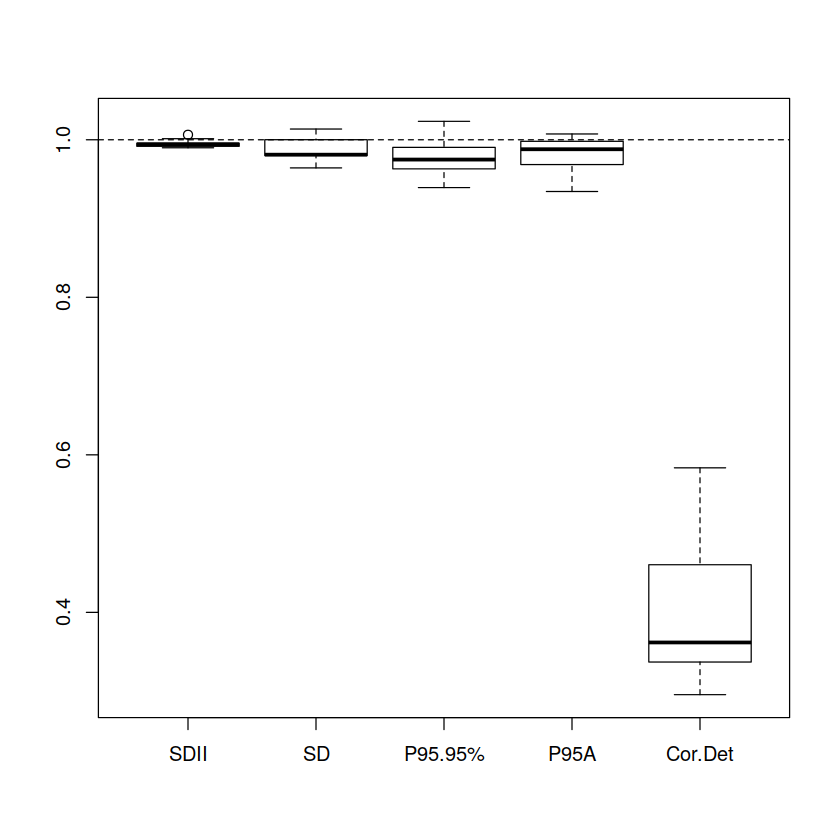

In [18]:
validation <- 
    lapply(predictions, function(station.predictions){  # loop covering each meteorological station
        # generating 250 simulations from the predicted shape and rate parameters
        observed <- station.predictions$observed
        simulations <- randomForestSimulate(prediction = station.predictions$predicted, 
                                            distr = "gamma", n = 250)


        # validating each simulation
        stochastic.validation <-
            apply(simulations, MARGIN = 2, FUN = function(simulation){# for each simulation

                P95.simulated <- quantile(simulation, probs = 0.95)
                P95.observed <- quantile(observed, probs = 0.95)

                return(
                    c(SDII = mean(simulation)/mean(observed),
                      SD = sd(simulation)/sd(observed),
                      P95 = P95.simulated/P95.observed,
                      P95A = sum(simulation[simulation >= P95.simulated])/sum(observed[observed >= P95.observed])
                     )
                )
            })

        # averaging the 250 values obtained for each validation metric
        stochastic.validation <- rowMeans(stochastic.validation)

        # correlation is computed for the deterministic series of predicted rainfall; recall E[X] = alpha/beta
        alphas <- station.predictions$predicted[ , 1]
        betas <- station.predictions$predicted[ , 2]
        correlation <- cor(alphas/betas, observed, method = "spearman")

        return(c(stochastic.validation, Cor.Det = correlation))

    })

validation <- t(simplify2array(validation))

# plotting the results
boxplot(validation)   
abline(h = 1, lty = 2)